In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
import numpy as np
import os
import pickle
from IPython.core.debugger import set_trace
import sys
import PIL
from PIL import Image
from matplotlib import pyplot as plt


# load loss functions
import sys
sys.path.append('./../loss')
from loss_provider import LossProvider

In [2]:
dataset_path = './../datasets/MNIST/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
data_dim = (1,32,32)
data_size = np.prod(data_dim)
batch_size = 50
allowed_labels = [0,1,2,3,4,5,6,7,8,9]

loss_provider = LossProvider()
results = {}

In [3]:
def filter_set(dataset, allowed_labels):
    to_drop = [i for i in range(len(dataset)) if dataset[i][1] in allowed_labels]
    return torch.utils.data.Subset(dataset, to_drop)
  
# key word args for loading data
kwargs = {'num_workers': 1, 'pin_memory': True} if device == "cuda" else {}

# transformers
transformers = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),         # grayscale images
    transforms.Pad((data_dim[1] - 28) // 2, fill=0, padding_mode='constant'), # padding
    transforms.ToTensor()                                # as tensors
])

train_set = datasets.ImageFolder(dataset_path + 'train/', transform=transformers)
test_set = datasets.ImageFolder(dataset_path + 'test/', transform=transformers)

# filter labels
train_set = filter_set(train_set, allowed_labels)
test_set = filter_set(test_set, allowed_labels)

# load datasets and make them easily fetchable in DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

# load datasets and make them easily fetchable in DataLoaders
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)



# Data loading

In [0]:
# helper function

def img_to_tensor(img, pad=0):
    img = np.array(img)
    if len(img.shape) > 2:
        # color image
        img = np.swapaxes(img, 0,2)
        img = img[np.newaxis]
    else:
        # greyscale image
        img = np.pad(img, pad, 'constant')
        img = img[np.newaxis, np.newaxis]
    img = img / 255
    return torch.tensor(img, dtype=torch.float32)

to_img_torch = transforms.ToPILImage()

def tensor_to_img(x):
    if len(x.shape) == 4:
        x = x[0] # only the first sample if multiple are present.
    img = to_img_torch(x)
    # upsampling. Otherwhgise pdf viewers will fuck with the interpolation
    w, h = img.size
    return img.resize((w*8, h*8), resample=PIL.Image.NEAREST)

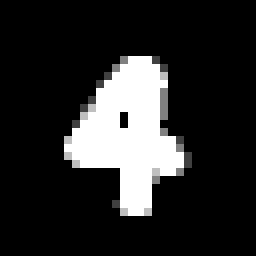

In [7]:
for data, lable in test_loader:
    x = data
    break
    
tensor_to_img(x[0])

# We reconstruct an inut sample, and plot the loss along the way!

In [0]:
EPS = 10**-14

In [0]:
class ReconSample(nn.Module):
    def __init__(self, ground_truth, loss_function):
        super().__init__()
        self.add_module('loss', loss_function)
        self.recon = nn.Parameter(torch.randn(ground_truth.shape))
        self.sigmoid = nn.Sigmoid()
        
    def get_recon(self):
        return self.sigmoid(self.recon)
    
    def forward(self, ground_truth):
        return self.loss(self.get_recon(), ground_truth)
    
def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def reconstruct(x, loss_function, epochs=10000, lr=10**-4):
    reconstructor = ReconSample(x, loss_function)
    reconstructor = reconstructor.to(device)
    x = x.to(device)
    optimizer = torch.optim.Adam(reconstructor.parameters(), lr=lr)
    l2_loss = nn.MSELoss(reduction='none')
    
    sample_cnt = x.shape[0]
    
    losses = np.zeros((sample_cnt, epochs))
    comparison_losses = np.zeros((sample_cnt, epochs))
    
    # train
    for iter in tqdm(range(epochs), leave=True, position=0):
        optimizer.zero_grad()
        loss = reconstructor.forward(x)
        comparison_loss = l2_loss(reconstructor.get_recon(), x)
        total_loss = torch.sum(loss)
        total_loss.backward()
        optimizer.step()
        loss_per_sample = torch.sum(loss.reshape(sample_cnt, -1), dim=1)
        comparison_loss_per_sample = torch.sum(comparison_loss.reshape(sample_cnt, -1), dim=1)
        losses[:, iter] = loss_per_sample.detach().cpu().numpy()
        comparison_losses[:, iter] = comparison_loss_per_sample.detach().cpu().numpy()
        
    # normalize
    losses = losses / losses[:,0, None]
    comparison_losses = comparison_losses / comparison_losses[:,0, None]
    means = np.mean(losses, axis=0)
    stds = np.std(losses, axis=0)
    log_stds = np.std(np.log(np.abs(losses) + EPS), axis=0)
    comparison_means = np.mean(comparison_losses, axis=0)
    comparison_stds = np.std(comparison_losses, axis=0)
    comparison_log_stds = np.std(np.log(np.abs(comparison_losses) + EPS), axis=0)
    return {'recons':reconstructor.get_recon().detach().cpu(), 'means':means, 'stds':stds, 'log_stds':log_stds, 'l2_means':comparison_means, 'l2_stds':comparison_stds, 'l2_log_stds':comparison_log_stds}
        

In [67]:
for (loss_metric, lr) in [('L2', 10**-4), ('SSIM', 10**-4), ('Watson-fft', 10**-3), ('Deeploss-vgg', 10**-4)]:
    print('\nEval metric {}'.format(loss_metric))
    loss_function = loss_provider.get_loss_function(loss_metric, 'LA', reduction='none')
        
    results[loss_metric] = reconstruct(x, loss_function, epochs=100000, lr=lr)
    pickle.dump(results, open('convergence_results_v3.pickle', 'wb'))
    

  0%|          | 113/100000 [00:00<01:29, 1121.56it/s]


Eval metric L2


  0%|          | 9/100000 [00:00<19:27, 85.63it/s]


Eval metric SSIM


  0%|          | 15/100000 [00:00<11:09, 149.30it/s]


Eval metric Watson-fft


100%|██████████| 100000/100000 [11:09<00:00, 149.40it/s]



Eval metric Deeploss-vgg


100%|██████████| 100000/100000 [2:07:30<00:00, 13.05it/s]


In [0]:
results = pickle.load(open('convergence_results_v3.pickle', 'rb'))

In [0]:
colors = {'L2':'black',
         'SSIM':'dimgrey',
         'Watson-fft':'blue',
         'Watson-fft-shadow':'darkblue',
         'Deeploss-vgg':'red',
         'Deeploss-vgg-shadow':'maroon',}

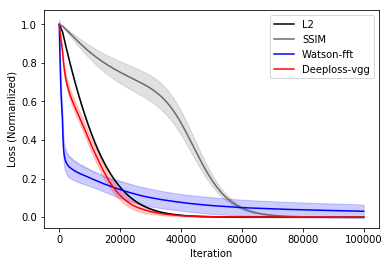

In [126]:
def smooth(a, running_interval=1000):
    n = len(a)
    b = a.copy()
    for i in range(0, n):
        b[i] = a[max(0, i-running_interval):i+1].mean()
    return b

for metric in results:
    metric_results = results[metric]
    means, stds, stds =  metric_results['means'], metric_results['stds'], metric_results['stds']
    means = smooth(means)
    stds = smooth(stds)
    
    plt.plot(means, label=metric, color=colors[metric])
    plt.fill_between([i for i in range(len(means))], means - stds, means + stds, alpha=0.2, color=colors[metric])
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss (Normanlized)')
plt.savefig('convergence_plot.pdf')

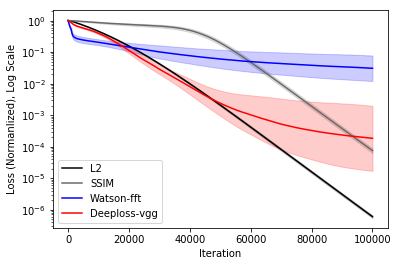

In [129]:
def smooth(a, running_interval=1000):
    n = len(a)
    b = a.copy()
    for i in range(0, n):
        b[i] = a[max(0, i-running_interval):i+1].mean()
    return b

for metric in results:
    metric_results = results[metric]
    means, stds, log_stds =  metric_results['means'], metric_results['stds'], metric_results['log_stds']
    means = smooth(means)
    log_stds = smooth(log_stds)
    
    plt.semilogy(means, label=metric, color=colors[metric])
    plt.fill_between([i for i in range(len(means))], np.exp(np.log(means)-log_stds), np.exp(np.log(means)+log_stds), alpha=0.2, color=colors[metric])
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss (Normanlized), Log Scale')
plt.savefig('convergence_logplot.pdf')

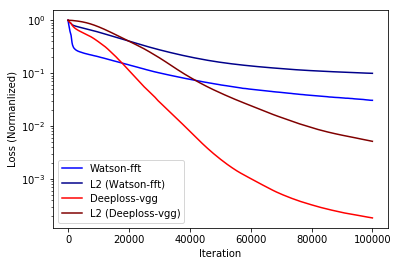

In [131]:

metric_results = results['Watson-fft']
wat_means, wat_l2 = metric_results['means'], metric_results['l2_means']
wat_means = smooth(wat_means)
wat_l2 = smooth(wat_l2)

metric_results = results['Deeploss-vgg']
deep_means, deep_l2 = metric_results['means'], metric_results['l2_means']
deep_means = smooth(deep_means)
deep_l2 = smooth(deep_l2)

plt.semilogy(wat_means, label='Watson-fft', color=colors['Watson-fft'])
plt.semilogy(wat_l2, label='L2 (Watson-fft)', color=colors['Watson-fft-shadow'])
plt.semilogy(deep_means, label='Deeploss-vgg', color=colors['Deeploss-vgg'])
plt.semilogy(deep_l2, label='L2 (Deeploss-vgg)', color=colors['Deeploss-vgg-shadow'])
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss (Normanlized)')
plt.savefig('convergence_l2_plot.pdf')

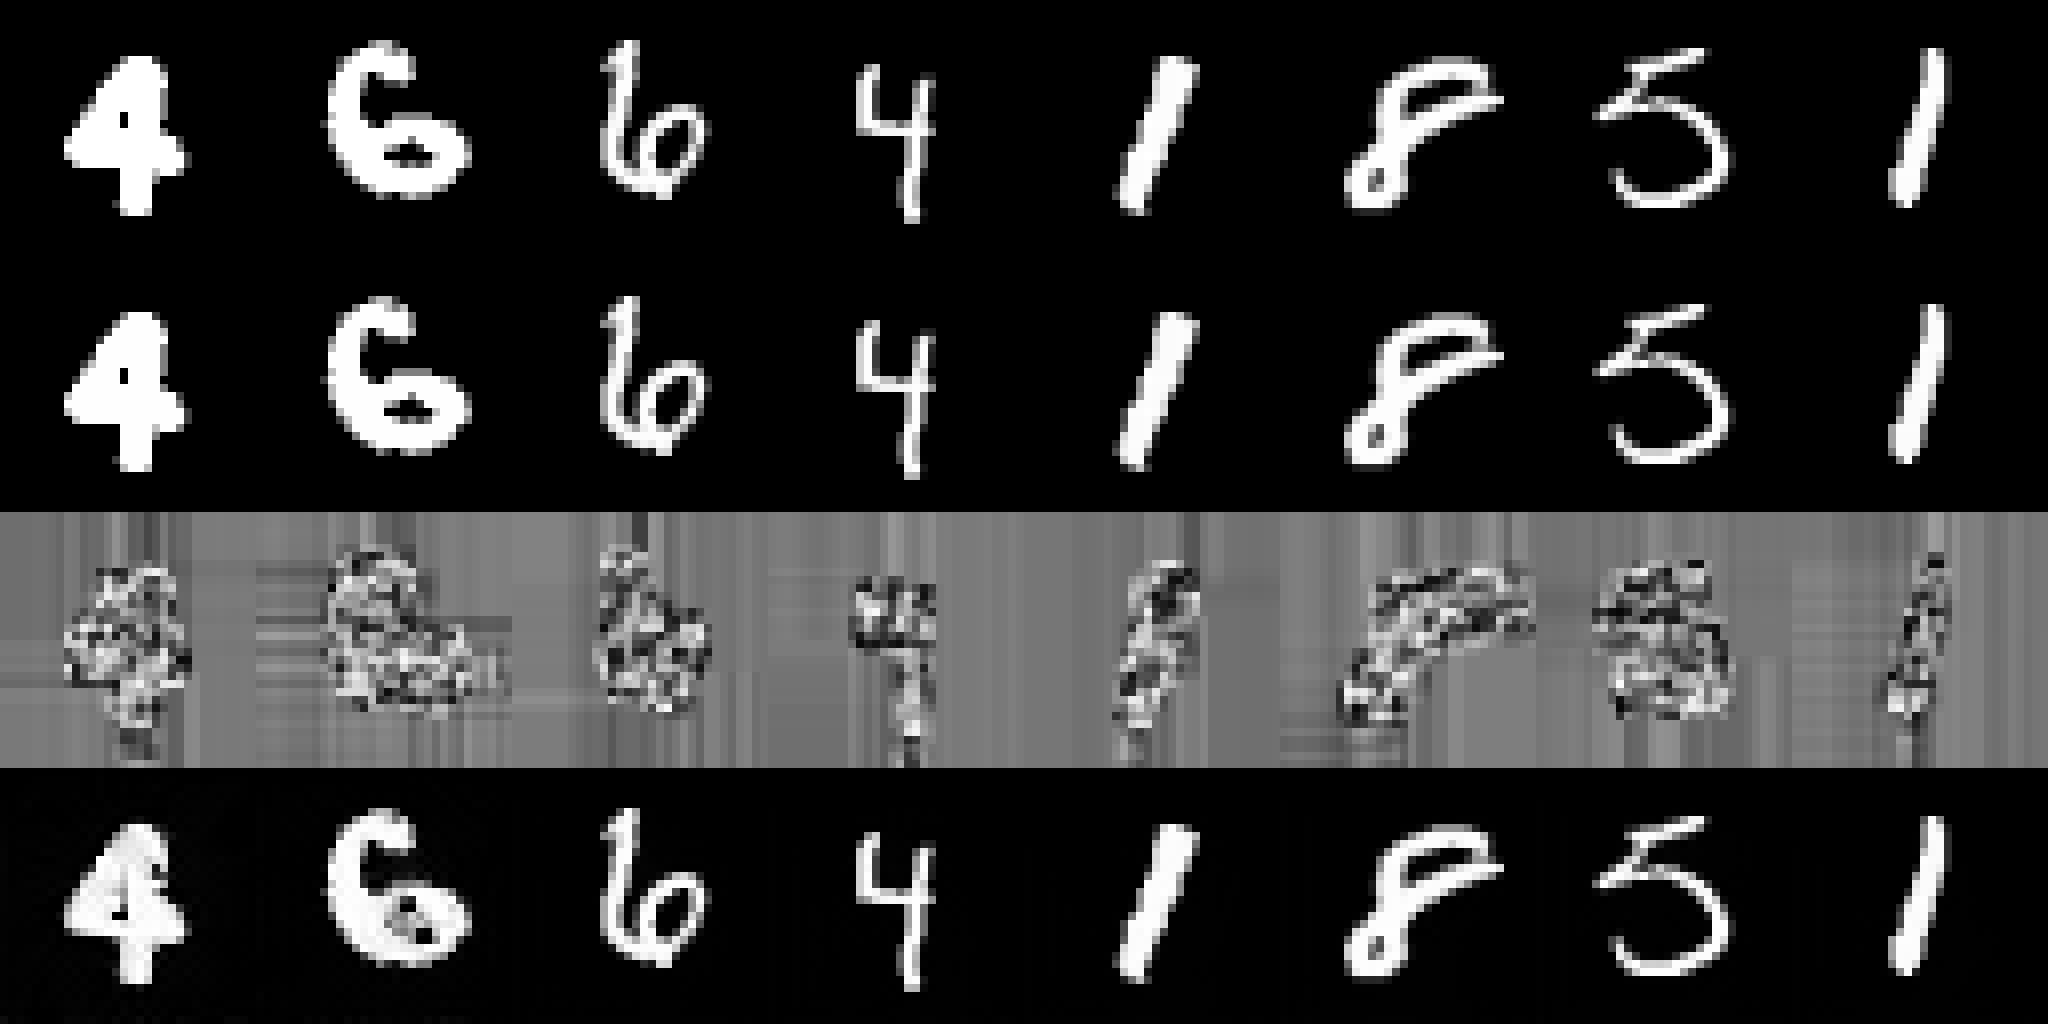

In [114]:
N = 8

samples = x[:N]

for metric in ['SSIM', 'Watson-fft', 'Deeploss-vgg']:
    metric_results = results[metric]
    recons = metric_results['recons']
    samples = torch.cat([samples, recons[:N]])
    

grid = torchvision.utils.make_grid(samples, nrow=N, padding=0)
img = tensor_to_img(grid)

img.save(os.path.join('convergence_results.jpg')

img